# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange

In [2]:
TZ = 'Asia/Shanghai'

In [3]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [4]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_latest.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [5]:
data['timestamp'] = data.index.tolist()

In [6]:
data

,open,high,low,close,volume,timestamp
2019-01-01 16:00:00+08:00,3850.000000,3850.00000,3849.600000,3849.60000,0.443293,2019-01-01 16:00:00+08:00
2019-01-01 16:01:00+08:00,3849.500000,3853.00000,3849.400000,3853.00000,9.085920,2019-01-01 16:01:00+08:00
2019-01-01 16:02:00+08:00,3853.000000,3857.00000,3852.960000,3853.20000,8.213360,2019-01-01 16:02:00+08:00
2019-01-01 16:03:00+08:00,3853.000000,3853.10000,3851.200000,3852.20000,6.385190,2019-01-01 16:03:00+08:00
2019-01-01 16:04:00+08:00,3852.200000,3852.30000,3852.200000,3852.30000,0.504622,2019-01-01 16:04:00+08:00
...,...,...,...,...,...,...
2020-12-07 15:55:00+08:00,19398.841056,19402.00000,19398.841056,19402.00000,8.340088,2020-12-07 15:55:00+08:00
2020-12-07 15:56:00+08:00,19402.690321,19418.62931,19402.690321,19418.62931,2.047179,2020-12-07 15:56:00+08:00
2020-12-07 15:57:00+08:00,19412.000000,19419.00000,19412.000000,19419.00000,0.153671,2020-12-07 15:57:00+08:00
2020-12-07 15:58:00+08:00,19410.000000,19414.00000,19410.000000,19414.00000,0.633814,2020-12-07 15:58:00+08:00


In [7]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 

# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

In [8]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

## Augment with same features in previous timestamps

In [9]:
new_feature_set = []
for feature in feature_set:
    data[f'{feature}_p1h'] = data[feature].shift(60)
    data[f'{feature}_p1d'] = data[feature].shift(1440)
    data[f'{feature}_p5d'] = data[feature].shift(7200)
    new_feature_set += [feature, f'{feature}_p1h', f'{feature}_p1d', f'{feature}_p5d']
feature_set = new_feature_set

In [10]:
print(f'Total feature number {len(feature_set)}')

Total feature number 80


## Show distribution of return in 1d 

C:\Users\Yuan\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Yuan\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([9.00000e+00, 5.60000e+01, 3.20000e+02, 1.95000e+02, 5.63000e+02,
        1.26600e+03, 3.88500e+03, 5.76200e+03, 1.46120e+04, 4.65010e+04,
        1.37749e+05, 3.97512e+05, 2.54872e+05, 7.25690e+04, 2.87060e+04,
        9.17900e+03, 6.52600e+03, 3.46900e+03, 1.22700e+03, 2.61000e+02,
        2.04000e+02, 1.23000e+02, 1.93000e+02, 2.68000e+02, 1.59000e+02,
        1.02000e+02, 9.70000e+01, 9.90000e+01, 6.60000e+01, 6.70000e+01,
        4.30000e+01, 8.80000e+01, 5.00000e+01, 3.00000e+01, 2.20000e+01,
        1.20000e+01, 1.00000e+01, 4.10000e+01, 4.10000e+01, 4.00000e+01,
        1.10000e+01, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.20000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.28686676, -0.26269117, -0.23851558, -0.21433999, -0.19016441,
        -0.16598882, -0.14181323, -0.11763764, -0.09346206, -0.06928647,
        -0.04511088, -0.0209353 ,  0.00324029,  0.02741588,  0.05159147,
         0.07576705,  0.09994264,  0.12411823,  0

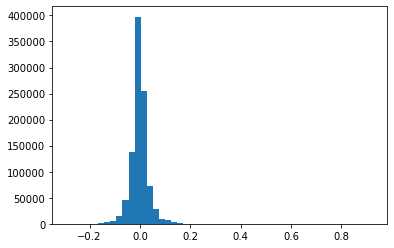

In [11]:
plt.hist(data['close'] / data['close'].shift(-1440) - 1,bins=50)

In [12]:
data['up_x%_in_1d_label'] = 100 * (data['close'].shift(-60) / data['close'] - 1)

In [13]:
data=data.dropna()

## Data Preparation

In [14]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2020-4-1', tz=TZ)
val_start_time = pd.Timestamp('2020-4-1', tz=TZ)
val_end_time = pd.Timestamp('2020-08-01', tz=TZ)
test_start_time = pd.Timestamp('2020-08-01', tz=TZ)
test_end_time = pd.Timestamp('2020-12-31', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

## Discritize continuous features

In [15]:
X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

In [18]:
X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

## Construct labels

In [19]:
label = ['up_x%_in_1d_label']

positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
y_train_soft = np.zeros((len(y_train),2))
y_train_soft[:,1] = np.clip(1 + train_data[label].values.squeeze() - positive_threshold, 0, 1)
y_train_soft[:,0] = 1 - y_train_soft[:,1]

#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
y_val_soft = np.zeros((len(y_val),2))
y_val_soft[:,1] = np.clip(1 + val_data[label].values.squeeze() - positive_threshold, 0, 1)
y_val_soft[:,0] = 1 - y_val_soft[:,1]

#Test
y_test = (test_data[label].values > positive_threshold).astype(int)
y_test_soft = np.zeros((len(y_test),2))
y_test_soft[:,1] = np.clip(0.5 + (test_data[label].values.squeeze()-positive_threshold), 0, 1)
y_test_soft[:,0] = 1 - y_test_soft[:,1]

In [20]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.053180608134529316
Positive ratio in val set: 0.03720489712436302
Positive ratio in test set: 0.036700351640062565


### Initialize Sample Reweighting & Feature Selection

In [21]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
from sample_reweight import SampleReweight
from featureSelection import featureSelection

In [23]:
LIMITED_SAMPLE = False # for debug only
EXAMPLES = 40000 if LIMITED_SAMPLE else X_train.shape[0]

# number of submodels
K = 5

ALPHA_1 = 1
ALPHA_2 = 1
NUM_BINS = 10
GAMMA = 0.9

# initialize feature selection parameters
NUM_BINS_FS = 3
ratio = [0.8, 0.6, 0.4]
feature_selected = np.arange(len(feature_set))

### Single model

In [25]:
model_single = GradientBoostingClassifier(random_state=0)
model_single.fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES].squeeze())

GradientBoostingClassifier(random_state=0)

### 5 submodels

In [27]:
clfs_5_sub = []

for i in tqdm(range(K)):
    clfs_5_sub.append(GradientBoostingClassifier(random_state=0))
    clfs_5_sub[i].fit(X_train[:EXAMPLES], y_train[:EXAMPLES].squeeze())

### +SR

In [28]:
clfs_SR = []

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

for i in tqdm(range(K)):
    clfs_SR.append(GradientBoostingClassifier(random_state=0))
    clfs_SR[i].fit(X_train[:EXAMPLES], y_train[:EXAMPLES].squeeze(), sample_weight=w)
    
    staged_pred = []
    
    for j, pred in enumerate(clfs_SR[i].staged_predict_proba(X_train[:EXAMPLES])):
        staged_pred.append(np.log(pred))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:EXAMPLES], y_train[:EXAMPLES], a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR[i], staged_pred)
    print(np.max(w))

12.82216013300389
12.62066006477104
12.496991655011406
12.53428011244967
12.935070832123008



### +FS

In [32]:
clfs_FS = []

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

list_feature_selected_FS = []
feature_selected = np.arange(len(feature_set))
list_feature_selected_FS.append(feature_selected.copy())

for i in tqdm(range(K)):
    clfs_FS.append(GradientBoostingClassifier(random_state=0))
    clfs_FS[i].fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES].squeeze(), sample_weight=w)
    
    staged_pred = []
    
    #feature selection
    feature_selected_index = featureSelection(clfs_FS[i], X_val[:EXAMPLES, feature_selected], y_val[:EXAMPLES], NUM_BINS_FS, ratio)
    feature_selected = feature_selected[feature_selected_index]
    print(feature_selected)
    list_feature_selected_FS.append(feature_selected.copy())

[ 0  1  2  4  5  7  8 11 12 15 16 18 20 22 25 26 27 28 29 30 31 32 33 34
 35 39 40 41 42 44 46 48 49 50 52 53 57 58 59 60 61 62 63 68 70 75 76 78]
[ 0  1  2  4  8 11 12 16 20 26 27 28 29 31 33 34 35 42 48 52 57 59 60 62
 63 68 70 75 78]
[ 0  4  8 20 27 28 29 33 34 35 48 52 59 60 62 63 75 78]
[ 0  4  8 20 27 28 29 33 35 52 63]
[ 0  4 27 33 52 63]



### +SR+FS

In [33]:
clfs_SR_FS = []

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

list_feature_selected_FS_SR = []
feature_selected = np.arange(len(feature_set))
list_feature_selected_FS_SR.append(feature_selected.copy())

for i in tqdm(range(K)):
    clfs_SR_FS.append(GradientBoostingClassifier(random_state=0))
    clfs_SR_FS[i].fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES].squeeze(), sample_weight=w)
    
    staged_pred = []
    
    for j, pred in enumerate(clfs_SR_FS[i].staged_predict_proba(X_train[:EXAMPLES, feature_selected])):
        staged_pred.append(np.log(pred))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES], a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR_FS[i], staged_pred)
    print(np.max(w))
    
    #feature selection
    feature_selected_index = featureSelection(clfs_SR_FS[i], X_val[:EXAMPLES, feature_selected], y_val[:EXAMPLES], NUM_BINS_FS, ratio)
    feature_selected = feature_selected[feature_selected_index]
    print(feature_selected)
    list_feature_selected_FS_SR.append(feature_selected.copy())

12.82216013300389
[ 0  1  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 22 24 26 28 30 31 32
 33 35 37 38 41 43 44 45 46 48 49 52 55 56 57 62 63 65 67 68 69 71 74 76]
12.968001067127224
[ 0  1  7  8  9 10 11 16 17 19 20 30 32 33 35 43 48 49 52 55 56 57 62 67
 68 69 71 74 76]
11.903487069590911
[ 1  7  8 19 20 30 32 33 35 43 49 52 55 57 62 69 74 76]
12.905602738993405
[ 7  8 20 32 33 35 52 55 57 62 76]
17.475895150987814
[ 7 20 33 52 62 76]



## Evaluate Model

In [34]:
from utils import eval_model, plot_roc, get_model_output

In [35]:
y_score_single = eval_model([model_single], X_test)

1
(1, 180298)
[-3.35859915 -3.09599844 -3.26037894 ... -3.2894895  -3.27929686
 -3.30995471]


In [36]:
y_score_5_sub = eval_model(clfs_5_sub, X_test)

5
(5, 180298)
[-3.35859915 -3.09599844 -3.26037894 ... -3.2894895  -3.27929686
 -3.30995471]


In [70]:
y_score_SR = eval_model(clfs_SR, X_test, mode='all')

5
(5, 180298)
[array([-3.36123856, -3.09990714, -3.26158918, ..., -3.29732735,
       -3.29395168, -3.32764292]), array([-3.36189841, -3.10088432, -3.26189174, ..., -3.29928681,
       -3.29761539, -3.33206497]), array([-3.36793829, -3.11489104, -3.26900113, ..., -3.30071955,
       -3.29886915, -3.33392253]), array([-3.36695397, -3.10442597, -3.26570532, ..., -3.29381665,
       -3.2857538 , -3.31530167]), array([-3.37578736, -3.11858547, -3.27039941, ..., -3.31817955,
       -3.31852448, -3.3474651 ])]


In [71]:
y_score_FS = eval_model(clfs_FS, X_test, feature_selected=list_feature_selected_FS, mode='all')

5
(5, 180298)
[array([-3.33294163, -3.02968588, -3.26709312, ..., -3.2236021 ,
       -3.20940703, -3.24407136]), array([-3.32652725, -3.01310775, -3.26877166, ..., -3.20713025,
       -3.19193457, -3.22760052]), array([-3.2934451 , -2.96927471, -3.25233832, ..., -3.09035799,
       -3.07338476, -3.10437419]), array([-3.24848336, -2.92651982, -3.24848336, ..., -2.9389604 ,
       -2.92651982, -2.92651982]), array([-3.04174323, -2.65096139, -3.04174323, ..., -2.65096139,
       -2.65096139, -2.65096139])]


In [72]:
y_score_SR_FS = eval_model(clfs_SR_FS, X_test, feature_selected=list_feature_selected_FS_SR, mode='all')

5
(5, 180298)
[array([-3.38577243, -3.08566013, -3.24352852, ..., -3.30094152,
       -3.298903  , -3.30503457]), array([-3.39256575, -3.08307555, -3.23931592, ..., -3.30380453,
       -3.30380453, -3.30380453]), array([-3.41330337, -3.13156011, -3.25717105, ..., -3.34107398,
       -3.34107398, -3.34107398]), array([-3.38552016, -3.2519772 , -3.25835943, ..., -3.4188689 ,
       -3.4188689 , -3.4188689 ]), array([-3.3267995, -3.3267995, -3.3267995, ..., -3.3267995, -3.3267995,
       -3.3267995])]


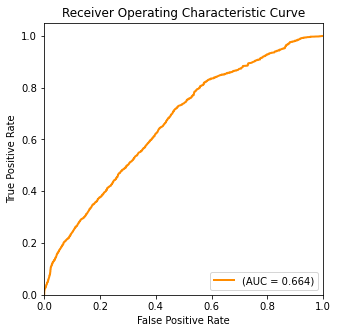

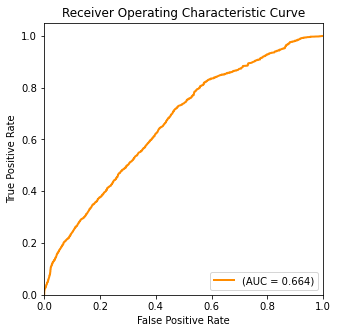

In [73]:
plot_roc(y_test, y_score_single)
plot_roc(y_test, y_score_5_sub)

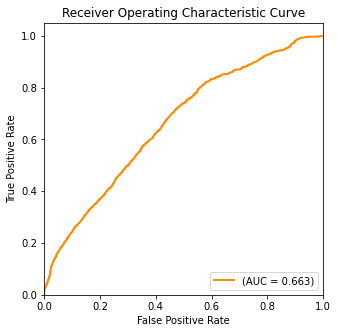

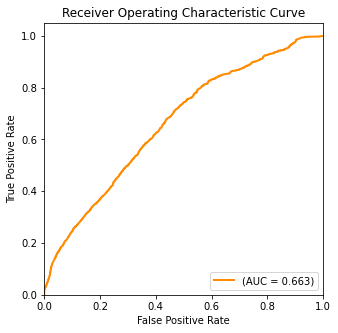

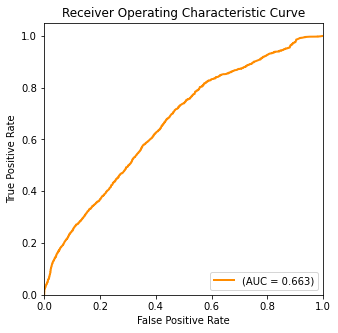

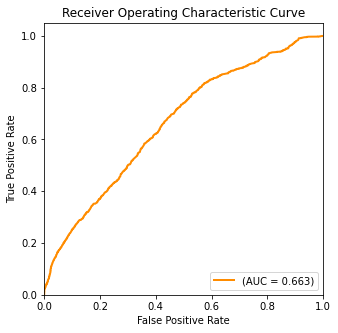

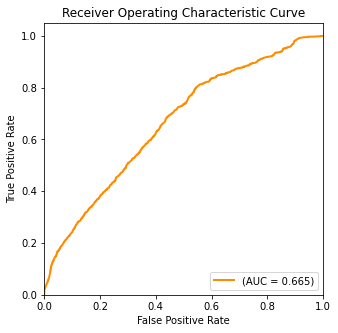

In [74]:
for y_score in y_score_SR:
    plot_roc(y_test, y_score)

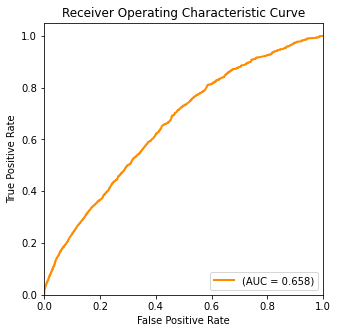

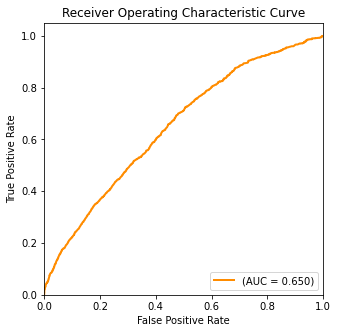

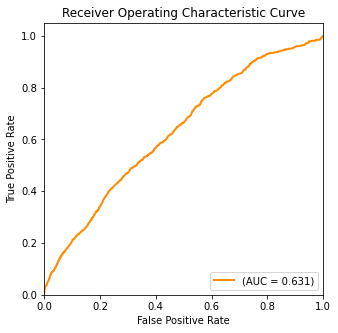

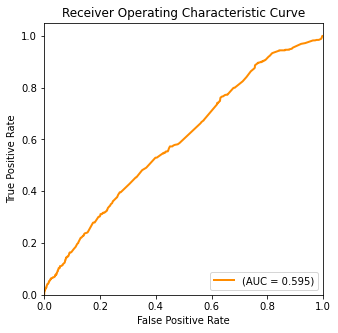

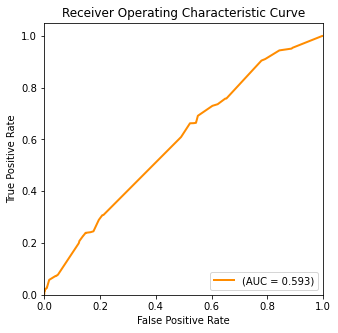

In [75]:
for y_score in y_score_FS:
    plot_roc(y_test, y_score)

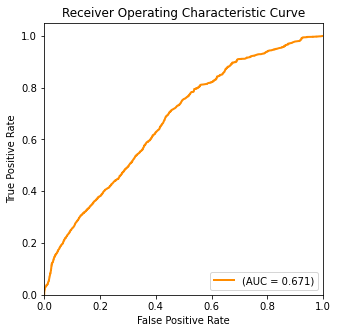

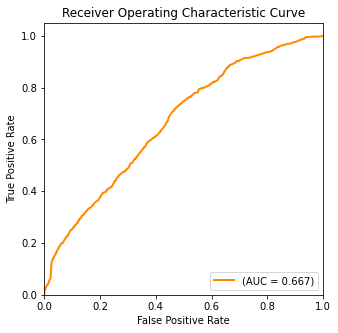

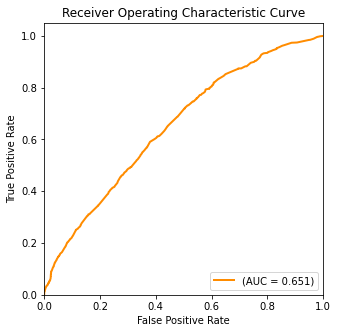

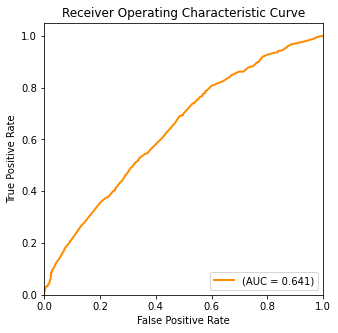

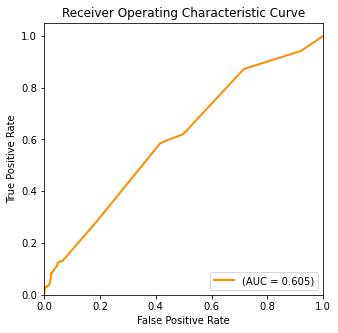

In [76]:
for y_score in y_score_SR_FS:
    plot_roc(y_test, y_score)

## Baseline (Correlation FS)

In [77]:
from utils import filter_by_corr

features = filter_by_corr(X_train)   

In [78]:
clfs_5_sub_base = []

for i in tqdm(range(K)):
    clfs_5_sub_base.append(GradientBoostingClassifier())
    clfs_5_sub_base[i].fit(X_train[:EXAMPLES, features], y_train[:EXAMPLES].squeeze())

5
(5, 180298)
[-3.3435626  -2.771147   -3.07902099 ... -2.86086951 -2.85308721
 -3.07184285]


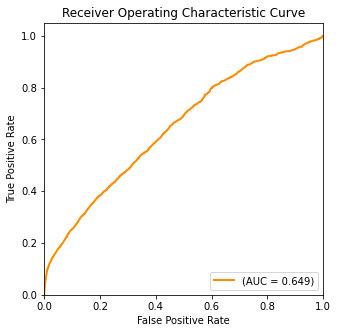

In [79]:
y_score_base = eval_model(clfs_5_sub_base, X_test, feature_selected=[features] * 5, mode='single')

plot_roc(y_test, y_score_base)

## Selected features

Text(0.5, 1.0, 'Slected Features')

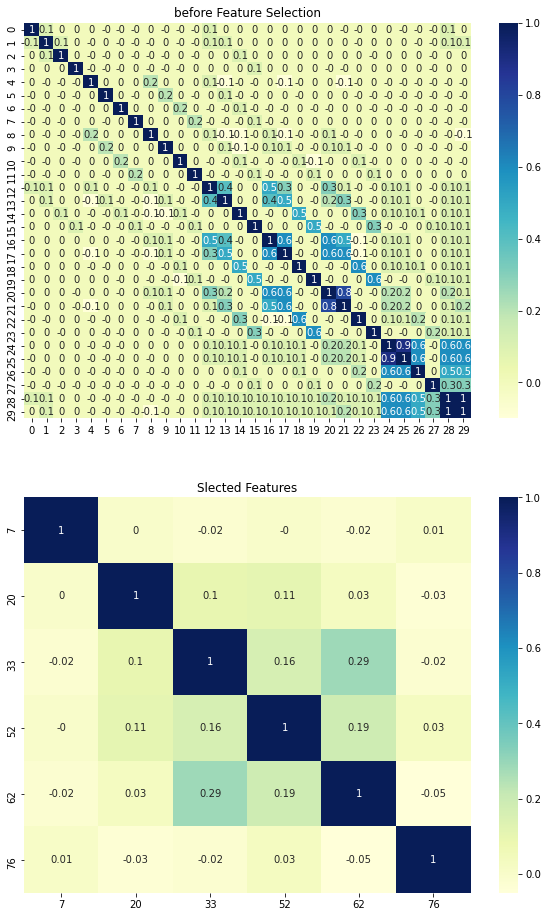

In [58]:
fig,  ax = plt.subplots(2, figsize=(10, 16))
correlation_matrix = pd.DataFrame.from_records(X_train[:, list_feature_selected_FS_SR[0][:30]]).corr().round(1)
sns.heatmap(correlation_matrix, cmap="YlGnBu", ax=ax[0], annot=True)

ax[0].set_title('before Feature Selection')

correlation_matrix = pd.DataFrame.from_records(X_train[:, list_feature_selected_FS_SR[-1]]).corr().round(2)
sns.heatmap(correlation_matrix, cmap="YlGnBu", ax=ax[1], annot=True, xticklabels=list_feature_selected_FS_SR[-1], yticklabels=list_feature_selected_FS_SR[-1], )

ax[1].set_title('Slected Features')
